<a id='top'></a>

# 1) Expected Goals Modeling using Wyscout Event Data - Data Parsing and Engineering
##### Notebook to create an Expected Goals (xG) model using a full season of publicly available [Wyscout](https://wyscout.com/) Event data

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/01/2021<br>
Notebook last updated: 31/01/2021

![title](../../../img/expected_goals_visual.png)

Photo credit to David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics?))

---

## <a id='import_libraries'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals (xG) model using a season's worth of [Wyscout](https://wyscout.com/) Event data for the 'Big 5' European leagues, in [Python](https://www.python.org/), using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

For more information about this notebook and the author, I'm available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/);
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster);
*    [kaggle.com/eddwebster](https://www.kaggle.com/eddwebster); and
*    [hackerrank.com/eddwebster](https://www.hackerrank.com/eddwebster).

![title](../../../img/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/football_analytics) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/football_analytics/blob/master/notebooks/A%29%20Web%20Scraping/TransferMarkt%20Web%20Scraping%20and%20Parsing.ipynb).

___

<a id='sectioncontents'></a>

## <a id='notebook_contents'>Notebook Contents</a>
1.    [Notebook Dependencies](#section1)<br>
2.    [Project Brief](#section2)<br>
3.    [Data Sources](#section3)<br>
      1.    [Introduction](#section3.1)<br>
      2.    [Data Dictionary](#section3.2)<br>
      3.    [Creating the DataFrame](#section3.3)<br>
      4.    [Initial Data Handling](#section3.4)<br>
      5.    [Export the Raw DataFrame](#section3.5)<br>         
4.    [Data Engineering](#section4)<br>
5.    [Feature Engineering](#section5)<br>
6.    [Machine Learning Modelling](#section6)<br>
7.    [Model Evaluation](#section7)<br>
8.    [Summary](#section8)<br>
9.    [Next Steps](#section9)<br>
10.    [Bibliography](#section10)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>

This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`Beautifulsoup`](https://pypi.org/project/beautifulsoup4/) for web scraping; and
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations;

All packages used for this notebook except for BeautifulSoup can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [46]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm    # Progress Bar

# Football libraries
import FCPython
#from FCPython import createPitch
import matplotsoccer
import socceraction.classification.features as features
import socceraction.classification.labels as labels
from socceraction.spadl.wyscout import convert_to_spadl
from socceraction.vaep import value

# Machine Learning
import scipy as sp
from scipy.spatial import distance
from sklearn.ensemble import RandomForestClassifier
#from sklearn.inspection import permutation_importance
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
from xgboost import XGBClassifier   # version 1.0.2
import catboost    # pip install catboost if you don't have it
from catboost import CatBoostClassifier, Pool, cv

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Setup Complete


In [47]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [48]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [49]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_wyscout = os.path.join(base_dir, 'data', 'wyscout')
scripts_dir = os.path.join(base_dir, 'scripts')
scripts_dir_wyscout = os.path.join(base_dir, 'scripts', 'wyscout')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_dir_wyscout = os.path.join(base_dir, 'img', 'fig', 'wyscout')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [50]:
# Define custom function to read JSON files that also handles the encoding of special characters e.g. accents in names of players and teams
def read_json_file(filename):
    with open(filename, 'rb') as json_file:
        return BytesIO(json_file.read()).getvalue().decode('unicode_escape')

### Notebook Settings

In [51]:
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
This notebook is the first in a series of notebooks to create an Expected Goals (xG) model using a the [publicly available 17/18 season of Wyscout match event dataset](https://figshare.com/collections/Soccer_match_event_dataset/4415000), using [pandas](http://pandas.pydata.org/) DataFrames, [XGBoost](https://xgboost.readthedocs.io/en/latest/) and [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

**References**:<br>
This notebook uses Wyscout data, made publicly available in the following paper by Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. **[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)**. In *Scientific Data 6*, no. 1 (2019): 1-15.

### <a id='#section2.2'>2.2. What is xG?</a>
["Expected goals"](https://en.wikipedia.org/wiki/Expected_goals) or more commonly known as 'xG', is a derived football metric, which allows you to evaluate team and player performance. In a low-scoring game such as football, final match score does not provide a clear picture of performance. More and more professional clubs and sports analytics teams are now turning to the advanced models like xG, which is a statistical measure of the quality of chances created and conceded.

As a metric, xG assesses every chance, essentially answering the question of whether a player should have scored from a certain opportunity. Put simply, it is a way of assigning a "quality" value (xG) to every attempt based on what we know about it. The higher the xG - with 1 being the maximum - the more likelihood of the opportunity being taken. So if a chance is 0.5xG, it should be scored 50% of the time.

xG was created by [Sam Green](https://twitter.com/aSamGreen) from [Opta](https://www.optasports.com/) after analysing over 300,000 shots to calculate the likelihood of an attempt being scored from a specific position on the pitch during a particular phase of play.

The factors taken into account when assessing the quality of a chance include:
*    Distance from goal
*    Angle of the shot
*    Did the chance fall at the player's feet or was it a header?
*    Was it a one on one?
*    What was the assist like? (eg long ball, cross, through ball, pull-back)
*    In what passage of play did it happen? (eg open play, direct free-kick, corner kick)
*    Has the player just beaten an opponent?
*    Is it a rebound?

The expected goals value reveals a number of things including:
*    Whether a chance really is as good as we think. While football is still a game that where debate and opinion make a huge part of the build up and analysis of matches, using xG we can now say with some certainty whether an opportunity should have been taken.
*    How many goals an individual player should be scoring from the chances their have. A striker might be top of the scoring charts, but does that necessarily mean he is the best finisher in the league? Previously we might have simply looked at their conversion rate (how many of their chances ended up as goals), but this did not provide the whole picture, as someone with a high conversion rate might just be the beneficiary of their team creating really clear-cut chances.
*    Team performance. If a team is performing above or below expectations at the start of the new season, a look at their expected goals difference could tell you whether that run is likely to last.

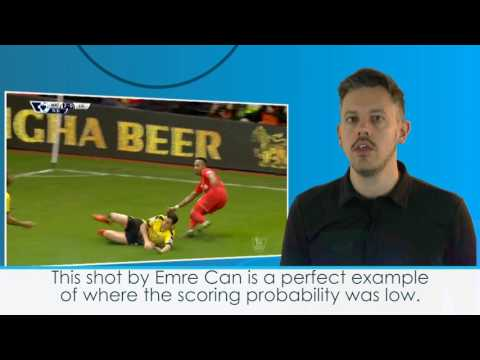

In [52]:
YouTubeVideo('w7zPZsLGK18')

---

## <a id='#section3'>3. Data Sources</a>

### <a id='#section3.1'>3.1. Introduction</a>

#### <a id='#section3.1.1'>3.1.1. About Wyscout</a>
[Wyscout](https://wyscout.com/) is an Italian company that supports football scouting, match analysis and transfer dynamics. The company was founded in Genoa, Italy in 2004 and provides video analysis tools and digital databases regarding performances and matches for coaches, teams and players dealing with football business.

![title](../../../img/wyscout_logo.png)

The purpose is to allow them have a detailed sight of a large number of athletes about individual performances, patterns of play and tactical strategy.

This notebook explores a complete dataset of event data for the Big 5 European leagues during the 17/18 season.

#### <a id='#section3.1.2'>3.1.2. About the Wyscout publicly available data</a>
A detailed description of the data can be found in the following paper:
- Pappalardo, L., Cintia, P., Rossi, A. et al. **A public data set of spatio-temporal match events in soccer competitions**. Scientific Data 6, 236 (2019) doi:10.1038/s41597-019-0247-7, https://www.nature.com/articles/s41597-019-0247-7

It is from this paper import the *matches*, *events*, *players*, *playerank*, *referees*, *coaches*, and *competition* data sets from the <a href="https://doi.org/10.6084/m9.figshare.c.4415000.v5">figshare repository</a>. Data are stored in the `JSON` format. 

The complete data set contains:
- 1,941 matches
- 3,251,294 events
- 4,299 players.

The datasets we will be using are:
- competitions;
- events;
- matches;
- players; and
- teams

The data needs to be imported as a DataFrame in the Data Sources section [Section 3](#section3) and cleaned in the Data Engineering section [Section 4](#section4).

### <a id='#section3.2'>3.2. Download the data</a>
This section downloads the Wyscout datasets if not already present in the data folder.

The following `data_files` dictionary lists the four data files in the Wyscout dataset that are required to run the VAEP framework.
*    `events` (73.74 MB): match events for the matches in the dataset;
*    `matches` (629.98 kB): overview of the matches in the dataset;
*    `players` (1.66 MB): information on the players in the dataset;
*    `teams` (26.76 kB): information on the teams in the dataset.

In [53]:
# Define dict in Python where the keys are the names of the files and the values are the corresponding URLs
data_files = {'events': 'https://ndownloader.figshare.com/files/14464685',     # ZIP file containing one JSON file for each competition
              'matches': 'https://ndownloader.figshare.com/files/14464622',    # ZIP file containing one JSON file for each competition
              'players': 'https://ndownloader.figshare.com/files/15073721',    # JSON file
              'teams': 'https://ndownloader.figshare.com/files/15073697'       # JSON file
             }

The following cell loops through the `data_files` dictionary, downloads each listed data file if it is not already present in the directory, and stores each downloaded data file to the local file system.

If the downloaded data file is a ZIP archive, the included JSON files are extracted from the ZIP archive and stored to the local file system.

In [54]:
# Download the listed data files for events, matches, players, and teams
if not os.path.exists(data_dir_wyscout + '/raw/json/'):
    for url in tqdm(data_files.values()):
        url_s3 = urlopen(url).geturl()
        path = Path(urlparse(url_s3).path)
        file_name = path.name
        file_local, _ = urlretrieve(url_s3, file_name)
        if is_zipfile(file_local):
            with ZipFile(file_local) as zip_file:
                zip_file.extractall()
else:
    pass    

### <a id='#section3.3'>3.3. Read in Data</a>
The following cells read the the JSON files into a `DataFrame` object.

####  <a id='#section3.3.1.'>3.3.1. Teams</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [55]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_teams = read_json_file(data_dir_wyscout + '/raw/json/' + 'teams.json')
df_teams = pd.read_json(json_teams)

In [56]:
# Display DataFrame
df_teams.head(10)

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alavés,696,Deportivo Alavés,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
5,Troyes,Troyes,3795,Espérance Sportive Troyes Aube Champagne,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
6,Getafe (Madrid),Getafe,698,Getafe Club de Fútbol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
7,Mönchengladbach,Borussia M'gladbach,2454,Borussia VfL Mönchengladbach,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
8,"Huddersfield, West Yorkshire",Huddersfield Town,1673,Huddersfield Town FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
9,Bilbao,Athletic Club,678,Athletic Club Bilbao,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


####  <a id='#section3.3.2.'>3.3.2. Players</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [57]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_players = read_json_file(data_dir_wyscout + '/raw/json/' + 'players.json')
df_players = pd.read_json(json_players)

In [58]:
# Display DataFrame
df_players.head(10)

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konaté,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konaté,null
5,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",83,Jasper,,Cillessen,676,1989-04-22,185,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",33,right,J. Cillessen,664
6,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",91,Toby,,Alderweireld,1624,1989-03-02,187,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",36,right,T. Alderweireld,5629
7,"{'name': 'Belgium', 'id': '56', 'alpha3code': ...",88,Jan,,Vertonghen,1624,1987-04-24,189,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Belgium', 'id': '56', 'alpha3code': ...",48,left,J. Vertonghen,5629
8,"{'name': 'France', 'id': '250', 'alpha3code': ...",74,Alexander,,Djiku,3783,1994-08-09,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",229427,right,A. Djiku,null
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712


####  <a id='#section3.3.3.'>3.3.3. Matches</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Define Competitions
The following cell lists the competitions to be included in the dataset. Dataset includes data for seven different competitions - 5 domestic and 2 international.

In [59]:
# Define a list to select only the competitions of interest. 
# For this Expected Goals model, I will use all the data available

# Define list of competitions
competitions = ['England',
                'France',
                'Germany',
                'Italy',
                'Spain',
                'European Championship',
                'World Cup'
               ]

##### Read JSON files
The following cells read the `matches.json` files for the selected competitions into a `DataFrame` object.

In [60]:
# Loop through the competition files for the selected competition(s)
# Take the separate JSON files each representing a match for the selected competition(s).
# The file is called matches_{competition_name}.json.
# Read the corresponding JSON matches files using the auxillary function
# Read JSON file as a pandas DataFrame
# Append the DataFrames to a list
# Finally, concatenate all the separate DataFrames into one DataFrame

## Create empty list for DataFrames
dfs_matches = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_matches list
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_matches = f'matches_{competition_name}.json'
    json_matches = read_json_file(data_dir_wyscout + '/raw/json/matches/' + file_matches)
    df_matches = pd.read_json(json_matches)
    dfs_matches.append(df_matches)

## Concatenate DataFrames to one DataFrame
df_matches = pd.concat(dfs_matches)

In [61]:
# Display DataFrame
df_matches.head(10)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId,groupName
0,Played,4405654,38,"{'1646': {'scoreET': 0, 'coachId': 8880, 'side...",181150,2018-05-13 14:00:00,1659,Turf Moor,2500089,"Burnley - AFC Bournemouth, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385705, 'role': 'referee'}, {'r...",Regular,364,NaN
1,Played,4405654,38,"{'1628': {'scoreET': 0, 'coachId': 8357, 'side...",181150,2018-05-13 14:00:00,1628,Selhurst Park,2500090,"Crystal Palace - West Bromwich Albion, 2 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381851, 'role': 'referee'}, {'r...",Regular,364,NaN
2,Played,4405654,38,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2018-05-13 14:00:00,1609,The John Smith's Stadium,2500091,"Huddersfield Town - Arsenal, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384965, 'role': 'referee'}, {'r...",Regular,364,NaN
3,Played,4405654,38,"{'1651': {'scoreET': 0, 'coachId': 8093, 'side...",181150,2018-05-13 14:00:00,1612,Anfield,2500092,"Liverpool - Brighton & Hove Albion, 4 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385704, 'role': 'referee'}, {'r...",Regular,364,NaN
4,Played,4405654,38,"{'1644': {'scoreET': 0, 'coachId': 93112, 'sid...",181150,2018-05-13 14:00:00,1611,Old Trafford,2500093,"Manchester United - Watford, 1 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 381853, 'role': 'referee'}, {'r...",Regular,364,NaN
5,Played,4405654,38,"{'1613': {'scoreET': 0, 'coachId': 210700, 'si...",181150,2018-05-13 14:00:00,1613,St. James' Park,2500094,"Newcastle United - Chelsea, 3 - 0","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 384888, 'role': 'referee'}, {'r...",Regular,364,NaN
6,Played,4405654,38,"{'1625': {'scoreET': 0, 'coachId': 267136, 'si...",181150,2018-05-13 14:00:00,1625,St. Mary's Stadium,2500095,"Southampton - Manchester City, 0 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 385911, 'role': 'referee'}, {'r...",Regular,364,NaN
7,Played,4405654,38,"{'10531': {'scoreET': 0, 'coachId': 32573, 'si...",181150,2018-05-13 14:00:00,1639,Liberty Stadium,2500096,"Swansea City - Stoke City, 1 - 2","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378952, 'role': 'referee'}, {'r...",Regular,364,NaN
8,Played,4405654,38,"{'1631': {'scoreET': 0, 'coachId': 209010, 'si...",181150,2018-05-13 14:00:00,1624,Wembley Stadium,2500097,"Tottenham Hotspur - Leicester City, 5 - 4","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 378951, 'role': 'referee'}, {'r...",Regular,364,NaN
9,Played,4405654,38,"{'1623': {'scoreET': 0, 'coachId': 8541, 'side...",181150,2018-05-13 14:00:00,1633,London Stadium,2500098,"West Ham United - Everton, 3 - 1","May 13, 2018 at 4:00:00 PM GMT+2","[{'refereeId': 408156, 'role': 'referee'}, {'r...",Regular,364,NaN


####  <a id='#section3.3.4.'>3.3.4. Events</a>
The following cells read the `events.json` files for the selected competitions into a `DataFrame` object.

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON files

In [62]:
# Loop through the competitions selected
# Read the corresponding events JSON files using the auxillary function
# Read JSON file as a pandas DataFrame
# Group the match events by match_id such that we end up with a separate DataFrame for each individual match
# Loop through each of the match DataFrames and read JSON file as a pandas DataFrame
# Append the DataFrames to a list
# Finally, concatenate all the separate DataFrames into one DataFrame

## Create empty list for DataFrames
dfs_events = []

## Loop through the competition files for the selected competition(s) and append DataFrame to dfs_events list
for competition in competitions:
    competition_name = competition.replace(' ', '_')
    file_events = f'events_{competition_name}.json'
    json_events = read_json_file(data_dir_wyscout + '/raw/json/events/' + file_events)
    df_events = pd.read_json(json_events)
    dfs_events.append(df_events)
    #df_events_matches = df_events.groupby('matchId', as_index=False)

## Concatenate DataFrames to one DataFrame
df_events = pd.concat(dfs_events)

In [67]:
# Display DataFrame
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


####  <a id='#section3.3.5'>3.3.5 Competitions</a>

##### Data Dictionary
The [Wyscout](https://wyscout.com/) Events dataset has twelve features (columns) with the following definitions and data types:

| Feature     | Data type    |
|------|-----|
| `eventId`    | int64     |
| `subEventName`    | object     |
| `tags`    | object     |
| `playerId`    | int64     |
| `positions`    | object     |
| `matchId`    | int64     |
| `eventName`    | object     |
| `teamId`    | int64     |
| `matchPeriod`    | object     |
| `eventSec`    | float64     |
| `subEventId`    | object     |
| `id`    | int64     |

Refer to the Wyscout [API docs](https://apidocs.wyscout.com/) and [Events Manual](https://footballdata.wyscout.com/wp-content/uploads/2018/03/Wyscout-Events-Manual.pdf) for further information about event and subevents.

##### Read JSON file

In [64]:
# Read JSON file as a JSON string and create a pandas DataFrame form the resulting JSON string
json_competitions = read_json_file(data_dir_wyscout + '/raw/json/' + 'competitions.json')
df_competitions = pd.read_json(json_competitions)

In [65]:
# Display DataFrame
df_competitions.head(10)

,name,wyId,format,area,type
0,Italian first division,524,Domestic league,"{'name': 'Italy', 'id': '380', 'alpha3code': '...",club
1,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,Spanish first division,795,Domestic league,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,French first division,412,Domestic league,"{'name': 'France', 'id': '250', 'alpha3code': ...",club
4,German first division,426,Domestic league,"{'name': 'Germany', 'id': '276', 'alpha3code':...",club
5,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international
6,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international


### <a id='#section3.4'>3.4. Join Datasets</a>
Next, we're required to join the `Matches` DataFrame and the `Players` DataFrame to the `Events` DatFrame. The `Events` data is the base DataFrame in which we join the other tables via `wyId`, `matchId`, `competitionId`, `playerId`, and `teamId`.

##### Join Matches DataFrame to Events DataFrame

In [68]:
# Join the Events DataFrame to the Matches DataFrame
df_wyscout_merge = pd.merge(df_events, df_matches, left_on='matchId', right_on='wyId')

##### Join Competitions DataFrame to Merged DataFrame via Events DataFrame

In [69]:
# Join the Competitions DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_competitions, left_on='competitionId', right_on='wyId')

##### Join Players DataFrame to Merged DataFrame via Events DataFrame

In [70]:
# Join the Players DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_players, left_on='playerId', right_on='wyId')

##### Join Teams DataFrame to Merged DataFrame via Events DataFrame

In [71]:
# Join the Players DataFrame to the Events-Matches DataFrame
df_wyscout_merge = pd.merge(df_wyscout_merge, df_teams, left_on='teamId', right_on='wyId')

In [72]:
# Display DataFrame
df_wyscout_merge.head(10)

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,name_y,wyId_y,officialName,area_y,type_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
3,8,Head pass,[{'id': 1802}],25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,82,177959276,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
4,1,Ground defending duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,12,177959303,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stad

In [73]:
df_wyscout_merge.shape

(3025256, 52)

### <a id='#section3.5'>3.5. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [74]:
# Display the first 5 rows of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,name_y,wyId_y,officialName,area_y,type_y
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,1,Air duel,"[{'id': 701}, {'id': 1802}]",25413,"[{'y': 54, 'x': 71}, {'y': 59, 'x': 50}]",2499719,Duel,1609,1H,22.551816,10,177959181,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
2,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,100,177959212,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
3,8,Head pass,[{'id': 1802}],25413,"[{'y': 70, 'x': 71}, {'y': 63, 'x': 71}]",2499719,Pass,1609,1H,397.881307,82,177959276,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stadium,2499719,"Arsenal - Leicester City, 4 - 3","August 11, 2017 at 8:45:00 PM GMT+2","[{'refereeId': 385909, 'role': 'referee'}, {'r...",Regular,364,NaN,English first division,364,Domestic league,"{'name': 'England', 'id': '0', 'alpha3code': '...",club,"{'name': 'Guadeloupe', 'id': 312, 'alpha3code'...",73,Alexandre,,Lacazette,1609,1991-05-28,175,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'France', 'id': 250, 'alpha3code': 'F...",25413,right,A. Lacazette,null,London,Arsenal,1609,Arsenal FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
4,1,Ground defending duel,"[{'id': 503}, {'id': 701}, {'id': 1802}]",25413,"[{'y': 64, 'x': 61}, {'y': 87, 'x': 51}]",2499719,Duel,1609,1H,494.461238,12,177959303,Played,4405654,1,"{'1609': {'scoreET': 0, 'coachId': 7845, 'side...",181150,2017-08-11 18:45:00,1609,Emirates Stad

In [75]:
# Display the last 5 rows of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.tail()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,name_y,wyId_y,officialName,area_y,type_y
3025251,8,Simple pass,[{'id': 1801}],116293,"[{'y': 72, 'x': 30}, {'y': 64, 'x': 42}]",2057995,Pass,17929,2H,2242.045496,85,260874786,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025252,1,Ground attacking duel,"[{'id': 504}, {'id': 703}, {'id': 1801}]",116293,"[{'y': 73, 'x': 37}, {'y': 48, 'x': 28}]",2057995,Duel,17929,2H,2501.224726,11,260874815,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025253,1,Air duel,"[{'id': 701}, {'id': 1802}]",116293,"[{'y': 70, 'x': 33}, {'y': 81, 'x': 23}]",2057995,Duel,17929,2H,2693.694869,10,260874832,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025254,8,Simple pass,[{'id': 1801}],116293,"[{'y': 52, 'x': 39}, {'y': 33, 'x': 39}]",2057995,Pass,17929,2H,2784.257941,85,260874843,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,16276,Mordovia Arena,2057995,"Panama - Tunisia, 1 - 2",2018-06-28 20:00:00-02:00,"[{'refereeId': 380581, 'role': 'referee'}, {'r...",Regular,28,Group G,World Cup,28,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XWO', 'al...",international,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",84,Harold Oshkaly,,Cummings Segura,7851,1992-03-01,180,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",116293,right,H. Cummings,17929,Ciudad de Panamá,Panama,17929,Panama,"{'name': 'Panama', 'id': 591, 'alpha3code': 'P...",national
3025255,8,High pass,[{'id': 1802}],116293,"[{'y': 65, 'x': 35}, {'y': 82, 'x': 69}]",2057995,Pass,17929,2H,2792.161774,83,260874845,Played,4165363,3,"{'17929': {'scoreET': 0, 'coachId': 90948, 'si...",10078,2018-06-28 18:00:00,

In [76]:
# Print the shape of the raw DataFrame, ddf_wyscout_merge
print(df_wyscout_merge.shape)

(3025256, 52)


In [77]:
# Print the column names of the raw DataFrame, df_wyscout_merge
print(df_wyscout_merge.columns)

Index(['eventId', 'subEventName', 'tags', 'playerId', 'positions', 'matchId',
       'eventName', 'teamId', 'matchPeriod', 'eventSec', 'subEventId', 'id',
       'status', 'roundId', 'gameweek', 'teamsData', 'seasonId', 'dateutc',
       'winner', 'venue', 'wyId_x', 'label', 'date', 'referees', 'duration',
       'competitionId', 'groupName', 'name_x', 'wyId_y', 'format', 'area_x',
       'type_x', 'passportArea', 'weight', 'firstName', 'middleName',
       'lastName', 'currentTeamId', 'birthDate', 'height', 'role', 'birthArea',
       'wyId_x', 'foot', 'shortName', 'currentNationalTeamId', 'city',
       'name_y', 'wyId_y', 'officialName', 'area_y', 'type_y'],
      dtype='object')


The dataset has fifty three features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [78]:
# Data types of the features of the raw DataFrame, df_wyscout_merge
df_wyscout_merge.dtypes

eventId                    int64
subEventName              object
tags                      object
playerId                   int64
positions                 object
matchId                    int64
eventName                 object
teamId                     int64
matchPeriod               object
eventSec                 float64
subEventId                object
id                         int64
status                    object
roundId                    int64
gameweek                   int64
teamsData                 object
seasonId                   int64
dateutc                   object
winner                     int64
venue                     object
wyId_x                     int64
label                     object
date                      object
referees                  object
duration                  object
competitionId              int64
groupName                 object
name_x                    object
wyId_y                     int64
format                    object
area_x    

All six of the columns have the object data type. Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [ ]:
# Info for the raw DataFrame, df_wyscout_merge
df_wyscout_merge.info()

In [ ]:
# Description of the raw DataFrame, df_wyscout_merge, showing some summary statistics for each numberical column in the DataFrame
df_wyscout_merge.describe()

In [ ]:
# Plot visualisation of the missing values for each feature of the raw DataFrame, df_wyscout_merge
msno.matrix(df_wyscout_merge, figsize = (30, 7))

In [ ]:
# Counts of missing values
null_value_stats = df_wyscout_merge.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

The visualisation shows us very quickly that there a few missing values in the `value` column, but otherwise the dataset is complete.

---

## <a id='#section4'>4. Data Engineering</a>
Before any Feature Engineering or Data Visualisation, we first need to clean and wrangle the datasets to a form that meet our needs.

### <a id='#section4.1'>4.1. Sort DataFrame</a>
Sort data by `matchId`, `matchPeriod`, and `eventSec`. Important for when determining previous events. which are attributes created for the DataFrame in the following section.

In [79]:
# Sort data by matchId, matchPeriod, and eventSec
df_wyscout_merge = df_wyscout_merge.sort_values(['matchId', 'matchPeriod', 'eventSec'])

### <a id='#section4.2'>4.2. Create attributes</a>

##### Create `league_name` column derived from the `competition_name_generic` column

In [80]:
dict_league_name_wyscout = {'Italy first division': 'Seria A',
                            'English first division': 'Premier League',
                            'Spanish first division': 'La Liga',
                            'French first division': 'Ligue 1',
                            'German first division': 'Bundesliga',
                            'European Championship': 'UEFA EURO',
                            'World Cup': 'FIFA World Cup'
                           }

In [81]:
#df_wyscout_merge['league_name'] = df_wyscout_merge['competition_name_generic'].map(dict_league_name_wyscout)

##### Create `fullName` attribute 
Join together the `firstName` and `lastName` attribute to create a `fullName` attribute.

In [82]:
df_wyscout_merge['fullName'] = df_wyscout_merge['firstName'].astype(str) + ' ' + df_wyscout_merge['lastName'].astype(str)

##### Create `previous_event` attribute 

In [83]:
df_wyscout_merge['previous_event'] = df_wyscout_merge['subEventName'].shift(1)

### <a id='#section4.3'>4.3. Rename Columns</a>

In [84]:
df_wyscout_merge = df_wyscout_merge.rename(columns={'name_y': 'teamName'})

### <a id='#section4.4'>4.4. Create Shots-only DataFrame</a>

In [85]:
"""
# In this example, only including shots, not freekicks. 
df_shots = df_wyscout_merge[(df_wyscout_merge['subEventName'] == 'Shot') |
                            (df_wyscout_merge['subEventName'] =='Free kick shot')
                           ].copy()
"""

"\ndf_shots = df_wyscout_merge[(df_wyscout_merge['subEventName'] == 'Shot') |\n                            (df_wyscout_merge['subEventName'] =='Free kick shot')\n                           ].copy()\n"

In [86]:
df_shots = df_wyscout_merge[(df_wyscout_merge['subEventName'] == 'Shot')].copy()

In [93]:
df_shots.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,teamName,wyId_y,officialName,area_y,type_y,fullName,previous_event
178870,10,Shot,"[{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...",25437,"[{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]",1694390,Shot,4418,1H,31.226217,100,88178649,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Angola', 'id': '24', 'alpha3code': '...",70,Blaise,,Matuidi,3159,1987-04-09,175,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",25437,left,B. Matuidi,4418,Paris,France,4418,France,"{'name': 'France', 'id': 250, 'alpha3code': 'F...",national,Blaise Matuidi,Head pass
2005128,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",83824,"[{'y': 29, 'x': 71}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,143.119551,100,88178722,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",78,Mihai Doru,,Pintilii,11565,1984-11-09,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Romania', 'id': 642, 'alpha3code': '...",83824,right,M. Pintilii,null,Bucureşti,Romania,11944,Romania,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",national,Mihai Doru Pintilii,Simple pass
2005391,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",33235,"[{'y': 57, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,219.576026,100,88178751,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Romania', 'id': '642', 'alpha3code':...",75,Bogdan Sorin,,Stancu,4502,1987-06-28,183,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Romania', 'id': '642', 'alpha3code':...",33235,right,B. Stancu,null,Bucureşti,Romania,11944,Romania,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",national,Bogdan Sorin Stancu,Air duel
2004350,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1215}, {'id'...",6165,"[{'y': 61, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,247.532561,100,88373458,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",78,Florin,,Andone,677,1993-04-11,180,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Romania', 'id': '642', 'alpha3code':...",6165,right,F. Andone,11944,Bucureşti,Romania,11944,Romania,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",national,Florin Andone,Air duel
181613,10,Shot,"[{'id': 401}, {'id': 2101}, {'id': 1802}]",3682,"[{'y'

In [96]:
number_of_shots = len(df_shots)
#number_of_goals = len(df_shots[df_shots['subEventName'] == 'Goal'])

print(f'Our dataset contains {number_of_shots:,} shots.')
#print(f'Our dataset contains {number_of_goals:,} goals.')
#print(f"Expected goal when shooting: {df_shots['goal'].mean()*100:.2f}%")

Our dataset contains 43,075 shots.


### <a id='#section4.5'>4.5. Create Shot Model</a>
Creation of the Open Player Shots Model from the Events data.

The following code is by David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics)). See his video [[link](https://www.youtube.com/watch?v=bpjLyFyLlXs)] and code [[link](https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py)].

In [97]:
# Create an empty DataFrame of shots
shots_model = pd.DataFrame(columns=['Goal',
                                    'X',
                                    'Y',
                                    'side_of_field',
                                    'left_foot', 
                                    'right_foot',
                                    'header',
                                    'counter_attack',
                                    'strong_foot'
                                   ]
                          )

In [99]:
# Go through the dataframe and calculate X, Y coordinates.
# Distance from a line in the centre
# Shot angle - calculated as the angle of the triangle created between the ball location and the two posts

## 
for i, shot in df_shots.iterrows():
    shots_model.at[i,'X']=100-shot['positions'][0]['x']
    shots_model.at[i,'Y']=shot['positions'][0]['y']
    shots_model.at[i,'side_of_field']= 1*(shot['positions'][0]['y'] <  50)
    shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
    #Distance in metres and shot angle in radians.
    x = shots_model.at[i,'X'] * 105 / 100
    y = shots_model.at[i,'C'] * 65 / 100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
    a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
    if a < 0:
        a=np.pi+a
    shots_model.at[i,'Angle'] =a
    shottags=[tag['id'] for tag in shot['tags']]
    if 101 in shottags:
        shots_model.at[i,'Goal']=1
    if 401 in shottags:
        shots_model.at[i, 'left_foot']=1
        if shot.loc['foot']=='left':
            shots_model.at[i, 'strong_foot'] = 1
    if 402 in shottags:
        shots_model.at[i, 'right_foot']=1
        if shot.loc['foot']=='right':
            shots_model.at[i, 'strong_foot'] = 1
    if 403 in shottags:
        shots_model.at[i, 'header']=1
    if 1901 in shottags:
        shots_model.at[i, 'counter_attack'] = 1

# Fill N/A values with 0        
shots_model = shots_model.fillna(0)

In [103]:
# Print the shape of the raw DataFrame, shots_model
print(shots_model.shape)

(43075, 12)


In [102]:
df_shots_merge = pd.merge(shots_model, df_shots, left_index=True, right_index=True, how='left')
df_shots_merge = df_shots_merge.reset_index(drop=True)

In [104]:
# Print the shape of the raw DataFrame, df_shots_merge
print(df_shots_merge.shape)

(43075, 66)


In [122]:
df_shots_merge

,Goal,X,Y,side_of_field,left_foot,right_foot,header,counter_attack,strong_foot,C,Distance,Angle,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId_x,label,date,referees,duration,competitionId,groupName,name_x,wyId_y,format,area_x,type_x,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId_x,foot,shortName,currentNationalTeamId,city,teamName,wyId_y,officialName,area_y,type_y,fullName,previous_event
0,0,9,29,1,0,1,0,0,0,21.0,16.601958,0.257917,10,Shot,"[{'id': 402}, {'id': 1401}, {'id': 1203}, {'id...",25437,"[{'y': 29, 'x': 91}, {'y': 0, 'x': 0}]",1694390,Shot,4418,1H,31.226217,100,88178649,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Angola', 'id': '24', 'alpha3code': '...",70,Blaise,,Matuidi,3159,1987-04-09,175,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",25437,left,B. Matuidi,4418,Paris,France,4418,France,"{'name': 'France', 'id': 250, 'alpha3code': 'F...",national,Blaise Matuidi,Head pass
1,0,29,29,1,0,1,0,0,1,21.0,33.369522,0.199901,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1216}, {'id'...",83824,"[{'y': 29, 'x': 71}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,143.119551,100,88178722,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",78,Mihai Doru,,Pintilii,11565,1984-11-09,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Romania', 'id': 642, 'alpha3code': '...",83824,right,M. Pintilii,null,Bucureşti,Romania,11944,Romania,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",national,Mihai Doru Pintilii,Simple pass
2,0,4,57,0,0,1,0,0,1,7.0,6.192132,0.889119,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1201}, {'id'...",33235,"[{'y': 57, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,219.576026,100,88178751,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Romania', 'id': '642', 'alpha3code':...",75,Bogdan Sorin,,Stancu,4502,1987-06-28,183,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Romania', 'id': '642', 'alpha3code':...",33235,right,B. Stancu,null,Bucureşti,Romania,11944,Romania,"{'name': 'Romania', 'id': 642, 'alpha3code': '...",national,Bogdan Sorin Stancu,Air duel
3,0,4,61,0,0,0,1,0,0,11.0,8.292316,0.506886,10,Shot,"[{'id': 403}, {'id': 201}, {'id': 1215}, {'id'...",6165,"[{'y': 61, 'x': 96}, {'y': 100, 'x': 100}]",1694390,Shot,11944,1H,247.532561,100,88373458,Played,4165470,1,"{'11944': {'scoreET': 0, 'coachId': 360105, 's...",9291,2016-06-10 19:00:00,4418,Stade de France,1694390,"France - Romania, 2 - 1",2016-06-10 21:00:00-02:00,"[{'refereeId': 383185, 'role': 'referee'}, {'r...",Regular,102,Group A,European Championship,102,International cup,"{'name': '', 'id': 0, 'alpha3code': 'XEU', 'al...",international,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",78,Florin,,Andone,677,1993-04-11,180,"{'code2': 'FW', 'code3': 'FWD', 'name': 'Forwa...","{'name': 'Romania', 'i

### <a id='#section4.6'>4.6. Streamline Shots DataFrame</a>

In [123]:
# Select columns of interest
cols = ['id',
        'matchId',
        'matchPeriod',
        'eventSec',
        'eventName',
        'subEventName',
        'previous_event',
        'teamId',
        'X',
        'Y',
        'playerId',
        'fullName',
        'strong_foot',
        'teamName',
        'Goal',
        'side_of_field',
        'left_foot', 
        'right_foot',
        'header',
        'counter_attack',
        'C',
        'Distance',
        'Angle'
       ]

# Create more concise DataFrame using only columns of interest
df_shots_merge_select = df_shots_merge[cols]

In [124]:
df_shots_merge_select.head()

,id,matchId,matchPeriod,eventSec,eventName,subEventName,previous_event,teamId,X,Y,playerId,fullName,strong_foot,teamName,Goal,side_of_field,left_foot,right_foot,header,counter_attack,C,Distance,Angle
0,88178649,1694390,1H,31.226217,Shot,Shot,Head pass,4418,9,29,25437,Blaise Matuidi,0,France,0,1,0,1,0,0,21.0,16.601958,0.257917
1,88178722,1694390,1H,143.119551,Shot,Shot,Simple pass,11944,29,29,83824,Mihai Doru Pintilii,1,Romania,0,1,0,1,0,0,21.0,33.369522,0.199901
2,88178751,1694390,1H,219.576026,Shot,Shot,Air duel,11944,4,57,33235,Bogdan Sorin Stancu,1,Romania,0,0,0,1,0,0,7.0,6.192132,0.889119
3,88373458,1694390,1H,247.532561,Shot,Shot,Air duel,11944,4,61,6165,Florin Andone,0,Romania,0,0,0,0,1,0,11.0,8.292316,0.506886
4,88178811,1694390,1H,557.319065,Shot,Shot,Simple pass,4418,25,33,3682,Antoine Griezmann,1,France,0,1,1,0,0,0,17.0,28.480959,0.236357


---

## <a id='#section5'>5. Export Data</a>
Export Data readu for building the Expected Goals models in the subsequent notebooks.

##### All Shots

In [125]:
# Export Shots DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv', 'shots_design_matrix.csv')):
    df_shots_merge_select.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv', 'shots_design_matrix.csv'), index=None, header=True)
else:
    pass

##### Events

In [ ]:
# Export DataFrame as CSV
if not os.path.exists(os.path.join(data_dir_wyscout, 'raw', 'csv','wyscout_complete.csv')):
    df_wyscout_merge.to_csv(os.path.join(data_dir_wyscout, 'raw', 'csv','wyscout_complete.csv'), index=None, header=True)
else:
    pass

---

## <a id='#section6'>6. Summary</a>
This notebook is a the first in a series of notebooks, to build a simple Expected Goals model that produces an Expected Goals value for each shot that happened during a game of football.

This notebook prepares the data to be used in the following notebooks to construct the xG models.

---

## <a id='#section7'>7. Next Steps</a>
The step is to take the dataset create in this notebook and build an xG model, first with Logistic Regression, and then next with XGBoost.

---

## <a id='#section8'>8. References</a>

#### Data
*    Luca Pappalardo, Paolo Cintia, Alessio Rossi, Emanuele Massucco, Paolo Ferragina, Dino Pedreschi, and Fosca Giannotti. "[A Public Data Set of Spatio-Temporal Match Events in Soccer Competitions](https://www.nature.com/articles/s41597-019-0247-7)" *Scientific Data 6*, no. 1 (2019): 1-15.(https://www.nature.com/articles/s41597-019-0247-7). Scientific Data 6, no. 1 (2019): 1-15.

#### Expected Goals models
*    [Tech how-to: build your own Expected Goals model by SciSports](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/)

---

## <a id='#section9'>9. Further Reading</a>
*    [The Future of Stats: xG, xA by Tifo Football Podcast](https://www.youtube.com/watch?v=sNCeA27sDvI)
*    [What is xG? YouTube video by Tifo Football](https://www.youtube.com/watch?v=zSaeaFcm1SY)
*    What are Expected Assists? YouTube video by Tifo Football](https://www.youtube.com/watch?v=1MdlkuzLdj4)
<br>

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)